# Data Processing

This notebook contains a workflow to:
1. Download hourly ERA5 data from a Google Cloud Storage bucket,
1. Process the hourly ERA5 data into daily ERA5 data with the fields necessary for our subsequent analysis, and
1. Upload the daily data to a Google Cloud Storage bucket.

This data processing is necessary to support an analysis of Earth's radiation budget based on daily solar fluxes at the surface and the top of atmosphere, so we will process hourly averages into daily averages. ERA5 does not output top of atmosphere outgoing solar radiation or upwelling solar radiation at the surface, however these quantities can be inferred using the available fluxes at those levels (e.g. incoming radiation and net radiation at the top of atmosphere).

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* The following Python packages:

In [1]:
%pip install -q tqdm xarray dask scipy netCDF4 joblib google-cloud-storage

Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
import contextlib
from datetime import timedelta, date
import logging
import multiprocessing
from os import system, path
from sys import platform
import time
import warnings

from google.cloud import storage
from tqdm.notebook import tqdm
import numpy as np
import joblib
from joblib import Parallel, delayed
import xarray as xr

### Setup

Our analysis seeks a long-term estimate of the amount of outgoing radiation that Earth's surface can reflect. ERA5 has 42 years of hourly data available. A long-term climatology is typically defined as 30 years. Thus, we ingest the latest 30 years: 1991 through 2020. Since making a single request would be prohibitively large, we break the request up by day. 

In [3]:
year = 2020
start_date = date(year, 1, 1)
end_date = date(year + 1, 1, 1)
hourly_data_bucket = "era5-single-level"
daily_data_bucket = "era5-single-level-daily"
n_jobs = -3  # number of jobs for parallelization; if 1, then serial; if negative, then (n_cpus + 1 + n_jobs) are used

xr.set_options(keep_attrs=True)
warnings.filterwarnings("ignore", category=FutureWarning)
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396
    
logging.basicConfig(filename="process.log", filemode="w", level=logging.INFO)

## Functions

In [4]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Patch joblib to report into tqdm progress bar given as argument."""

    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()


def daterange(start_date, end_date):
    """Make a date range object spanning two dates.
    
    Args:
        start_date: date object to start from.
        end_date: date object to end at.
    
    Yields:
        date object for iteration.
    """
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)


def get_date_data_gcs(single_date, bucket_name):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to download from.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage as a side effect.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(f"{single_date.strftime('%Y%m%d')}.nc")
    blob.download_to_filename(filename=f"./{single_date.strftime('%Y%m%d')}.nc")


def put_date_data_gcs(single_date, bucket_name):
    """Upload a dataset for a single date to Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to upload to.
        
    Returns:
        Nothing; uploads data to Google Cloud Storage as a side effect.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(f"{single_date.strftime('%Y%m%d')}.nc")
    blob.upload_from_filename(filename=f"./{single_date.strftime('%Y%m%d')}.nc")
    

def put_data_gcs(file_path, file_name, bucket_name):
    """Upload a file to Google Cloud Storage.
    
    Args:
        file_path: local path to file.
        file_name: filename to upload.
        bucket_name: Google Cloud Storage bucket to upload to.
        
    Returns:
        Nothing; uploads data to Google Cloud Storage as a side effect.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(file_name)
    blob.upload_from_filename(filename=path.join(file_path, file_name))
    

def check_blob_size(single_date, bucket_name, raise_threshold=1):
    """Verify that a GCS blob is larger than a specified threshold.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket_name: Google Cloud Storage bucket to upload to.
        raise_threshold: file size below which an exception should be raised.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.get_blob(f"{single_date.strftime('%Y%m%d')}.nc")
    if blob.size < raise_threshold:
        raise Exception(f"{single_date.strftime('%Y%m%d')} data file size is smaller than expected")
    else:
        logging.info(f"{single_date.strftime('%Y%m%d')} file size in GCS is {int(blob.size * 1e-6)}MB")


def modify_units(dataset, starting_units, ending_units, conversion_factor):
    """Modify the units of a variable.
    
    Args:
        dataset: xarray Dataset
        starting_units: str of units to be modified
        ending_units: str of units after modification
        conversion_factor: numerical factor to apply to convert units
    
    Returns:
        xarray Dataset with units modified for variables with units matching the starting unit.
    """
    for variable in dataset:
        if dataset[variable].attrs["units"] == starting_units:
            dataset[variable] = dataset[variable] * conversion_factor
            dataset[variable].attrs["units"] = ending_units
    return dataset

        
def compute_daily_average(dataset):
    """Compute the daily average and an input xarray dataset."""
    return dataset.resample(time='1D').sum() / dataset.sizes["time"]


def compute_boundary_fluxes(dataset):
    """Compute missing boundary fluxes at the surface and top of atmosphere if possible.
    
    Use available radiative fluxes e.g. net solar radiation and incoming solar radiation to 
    compute outgoing solar radiation.
    
    Args:
        dataset: xarray Dataset with radiative fluxes at the surface and top of atmosphere.
        
    Returns:
        xarray Dataset with missing fluxes at the boundaries.
    """
    if ("tosr" not in dataset) and all(x in dataset for x in ["tisr", "tsr"]):
        dataset["tosr"] = dataset["tisr"] - dataset["tsr"]
        dataset["tosr"].attrs["long_name"] = "TOA outgoing solar radiation"
        dataset["tosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    if ("ssru" not in dataset) and all(x in dataset for x in ["ssrd", "ssr"]):
        dataset["ssru"] = dataset["ssrd"] - dataset["ssr"]
        dataset["ssru"].attrs["long_name"] = "Surface solar radiation upwards"
        dataset["ssru"].attrs["standard_name"] = "surface_upwelling_shortwave_flux_in_air"
    return dataset


def compute_radiative_properties(dataset):
    """Compute new variables based on the model of Stephens et al. (2015).
    
    Stephens, G. L., O'Brien, D., Webster, P. J., Pilewski, P., Kato, S., 
    and Li, J. (2015), The albedo of Earth. Rev. Geophys., 53, 141–163. 
    doi: 10.1002/2014RG000449.
    
    Specifically, compute system reflectivity, transmittance, and surface albedo, then
    use those properties to compute the reflectance and transmittance of a 1-layer
    atmosphere following the simple model provided by Stephens et al.
    
    Finally, compute the surface contribution to outgoing solar radiation and the potential
    surface contribution to the outgoing solar radiation. These two properties are of
    particular interest to Reflective Earth in this analysis.
    
    Args:
        dataset: xarray dataset containing shortwave radiative fluxes at the surface
            and top of atmosphere.
            
    Returns:
        xarray dataset with additional variables added.
    """
    # System properties
    dataset["R"] = dataset["tosr"] / dataset["tisr"]
    dataset["R"] = fill_nas(dataset["R"])
    dataset["R"].attrs["long_name"] = "Planetary albedo"
    dataset["R"].attrs["standard_name"] = "planetary_albedo"
    dataset["R"].attrs["units"] = "1"
    
    dataset["T"] = dataset["ssrd"] / dataset["tisr"]
    dataset["T"] = fill_nas(dataset["T"])
    dataset["T"].attrs["long_name"] = "Planetary transmission"
    dataset["T"].attrs["standard_name"] = "planetary_transmittance"
    dataset["T"].attrs["units"] = "1"
    
    dataset["A"] = 1 - dataset["R"]
    dataset["A"] = fill_nas(dataset["A"])
    dataset["A"].attrs["long_name"] = "Planetary absorption"
    dataset["A"].attrs["standard_name"] = "planetary_aborptance"
    dataset["A"].attrs["units"] = "1"
    
    dataset["alpha"] = dataset["ssru"] / dataset["ssrd"]
    dataset["alpha"].attrs["long_name"] = "Surface albedo"
    dataset["alpha"].attrs["standard_name"] = "surface_albedo"
    dataset["alpha"].attrs["units"] = "1"

    # Intrinsic properties
    dataset["a"] = (dataset["tisr"] * dataset["A"] - dataset["ssrd"] * (1 - dataset["alpha"])) / dataset["tisr"]
    dataset["a"] = fill_nas(dataset["a"])
    dataset["a"].attrs["long_name"] = "1-layer atmospheric absorption"
    dataset["a"].attrs["standard_name"] = "atmosphere_absorptance"
    dataset["a"].attrs["units"] = "1"
    
    dataset["r"] = dataset["R"] - (dataset["alpha"] * dataset["T"]) * ((1 - dataset["alpha"] * dataset["R"]) /
                                                                       (1 - dataset["alpha"]**2 * dataset["T"]**2))
    dataset["r"] = fill_nas(dataset["r"])
    dataset["r"].attrs["long_name"] = "1-layer atmosphere reflectivity"
    dataset["r"].attrs["standard_name"] = "atmosphere_reflectance"
    dataset["r"].attrs["units"] = "1"
    
    dataset["t"] = 1 - dataset["r"] - dataset["a"]
    dataset["t"] = fill_nas(dataset["t"])
    dataset["t"].attrs["long_name"] = "1-layer atmospheric transmission"
    dataset["t"].attrs["standard_name"] = "atmosphere_transmittance"
    dataset["t"].attrs["units"] = "1"

    # Reflective properties
    dataset["srosr"] = dataset["tisr"] * (dataset["R"] - dataset["r"])
    dataset["srosr"].attrs["long_name"] = "Surface-reflected outgoing solar radiation"
    dataset["srosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["srosr"].attrs["units"] = "J m**-2"
    
    dataset["psrosr"] = dataset["tisr"] * (dataset["t"]**2 / (1 - dataset["r"]))
    dataset["psrosr"].attrs["long_name"] = "Potential surface-reflected outgoing solar radiation"
    dataset["psrosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["psrosr"].attrs["units"] = "J m**-2"
    
    test_data(dataset)

    return dataset


def test_data(dataset):
    """Check data for errors."""
    # Check for infinites
    assert dataset.psrosr.where(np.isinf(dataset.psrosr)).count() == 0
    assert dataset.srosr.where(np.isinf(dataset.srosr)).count() == 0
    assert dataset.t.where(np.isinf(dataset.t)).count() == 0
    assert dataset.r.where(np.isinf(dataset.r)).count() == 0
    assert dataset.a.where(np.isinf(dataset.a)).count() == 0


def fill_nas(dataarray):
    """Fill in NaN for certain conditions.
    
    Args:
        dataset: xarray DataArray.
    
    Returns:
        xarray DataArray with zeros filled in certain conditions.
    """
    dataarray = dataarray.where(~np.isinf(dataarray)).fillna(np.nan)  # fill infinite values with 0
    dataarray = dataarray.where(dataarray < 1).fillna(np.nan)  # fill values greater than 1 with 1
    dataarray = dataarray.where(dataarray > 0).fillna(np.nan)  # fill values less than 0 with 0
    
    return dataarray


def drop_unneccesary_variables(dataset, keep_vars):
    """Drop variables not specified as necessary.
    
    Args:
        dataset: xarray Dataset.
        keep_vars: list of variables to keep.
    
    Returns:
        xarray Dataset with specified variables.
    """
    drop_vars = list(set(dataset.data_vars).symmetric_difference(set(keep_vars)))
    return dataset.drop_vars(drop_vars)


def process_hourly_data(single_date, hourly_data_bucket, daily_data_bucket, cleanup=False):
    """Process hourly average data into daily average data.
    
    Args:
        single_date: date object representing day to retrieve data for.
        hourly_data_bucket: str name of Google Cloud Storage bucket for hourly data.
        daily_data_bucket: str name of Google Cloud Storage bucket for daily data.
        cleanup: boolean option to remove downloaded data after processing.
    
    Returns:
        Exit status of system call to upload processed data to Google Cloud Storage.
        
    Raises:
        Exception: if the same bucket is provided for both hourly and daily data.
    """
    if hourly_data_bucket == daily_data_bucket:
        raise Exception("You must provide different buckets for hourly and daily data.")
    
    get_date_data_gcs(single_date, hourly_data_bucket)
    
    with xr.open_dataset(f"./{single_date.strftime('%Y%m%d')}.nc") as ds:
        ds = compute_boundary_fluxes(ds)
        ds = compute_daily_average(ds)
        #ds = compute_radiative_properties(ds)
        ds = drop_unneccesary_variables(ds, keep_vars=["ssrd", "ssru", "tisr", "tosr"])
                                                       #"t", "r", "a", "srosr", "psrosr"])
        ds = modify_units(ds, "J m**-2", "W m**-2", (1 / 3600))  # 3600 seconds in an hour
        ds.to_netcdf(f"./{single_date.strftime('%Y%m%d')}.nc")

    put_date_data_gcs(single_date, daily_data_bucket)
    check_blob_size(single_date, daily_data_bucket, raise_threshold=1e+7)
    
    if cleanup:
        system(f"rm {single_date.strftime('%Y%m%d')}.nc")

## Workflow

For each day between the specified start and end dates, download the hourly data, process it, and upload it to a different bucket for daily data.

In [5]:
with tqdm_joblib(tqdm(total=sum(1 for _ in daterange(start_date, end_date)))) as pbar:
    Parallel(n_jobs=n_jobs,
             backend="multiprocessing")(delayed(process_hourly_data)(day, 
                                                                     hourly_data_bucket, 
                                                                     daily_data_bucket, 
                                                                     cleanup=False)
                                        for day in daterange(start_date, end_date))

  0%|          | 0/366 [00:00<?, ?it/s]

## Discussion

In the next notebook, `03-Analysis.ipynb` we'll investigate the results of the simple model of reflected sunlight that we implemented in the course of this data processing workflow.

In [6]:
ds = xr.open_mfdataset("*.nc", parallel=True)

In [7]:
def mean(obj, dim):
    # note: apply always moves core dimensions to the end
    return apply_ufunc(np.nanmean, obj, input_core_dims=[[dim]], kwargs={"axis": -1})

In [8]:
delayed_average = ds.mean(dim="time")

In [9]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_ann = delayed_average.compute()

[########################################] | 100% Completed | 15.3s


In [10]:
ds_ann.to_netcdf(f"./{year}.nc")

In [11]:
put_data_gcs(".", f"{year}.nc", "rom-input")

In [12]:
ds_all = compute_radiative_properties(ds_ann)

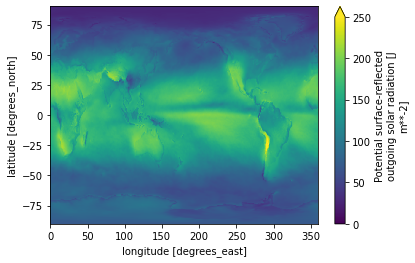

In [13]:
ds_all.psrosr.squeeze().plot.imshow(vmin=0, vmax=250)

In [14]:
system("rm -f ./*.nc")

0